# **Import required library**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam # type: ignore
from sklearn.metrics import  accuracy_score

# **Exploring the malware datasets**

Malware dataset is collected on [Kaggle by this link](https://www.kaggle.com/datasets/amauricio/pe-files-malwares) :

*   19611
unique values
*   6051 downloads and gain 135 downloads in the last 30 days
*   Traning model we use record from 0->7900
*   Also this dataset is mentioned in [paper](https://www.researchgate.net/publication/363847778_Impact_of_Portable_Executable_Header_Features_on_Malware_Detection_Accuracy#fullTextFileContent)

In [2]:
#import neccessary packages
import pandas as pd
import matplotlib.pyplot as plt

path = "dataset/dataset_malwares_modified.csv"
df = pd.read_csv(path)

In [3]:
# Explore the shape of the dataset
print("The shape of the dataset is: %d samples, %d features" % (df.shape[0], df.shape[1]))

The shape of the dataset is: 19611 samples, 79 features


# Features selection

* Detailed features selection explanation is provided in document
* We decide to drop some features that is similar among the dataset.
* We drop down some features that the existence of it does not affect the classification tasks such as LoaderFlags
* Based on the previous works such as [Ember](https://arxiv.org/abs/1804.04637), [Feature selection for RL](https://ieeexplore.ieee.org/document/8920059), [Impact of Portable Executable Header Features on Malware Detection Accuracy](https://www.researchgate.net/publication/363847778_Impact_of_Portable_Executable_Header_Features_on_Malware_Detection_Accuracy#fullTextFileContent)

In [4]:
# This is column that is listed in "Impact of Portble Executable Header Features on Malware Detection Accuracy"
#Now, let jump into further features reduction
'''"DllCharacteristics", "MajorImageVersion", "MajorOperatingSystemVersion", 
"SizeOfStackReserve", "AddressOfEntryPoint", "Characteristics", "SizeOfHeaders", 
"SizeOfInitializedData", "SizeOfUninitializedData", "MajorSubsystemVersion", 
"MinorSubsystemVersion", "CheckSum", "ImageBase", "MajorLinkerVersion", "NumberOfSections", 
"Subsystem", "MinorImageVersion", "SizeOfStackCommit", "e_lfanew", "e_minalloc", "e_ovno",
"Machine", "PointerToSymbolTable", "NumberOfSymbols", "Magic", "SizeOfCode", "BaseOfCode", 
"SectionAlignment", "FileAlignment","Malware"'''

'"DllCharacteristics", "MajorImageVersion", "MajorOperatingSystemVersion", \n"SizeOfStackReserve", "AddressOfEntryPoint", "Characteristics", "SizeOfHeaders", \n"SizeOfInitializedData", "SizeOfUninitializedData", "MajorSubsystemVersion", \n"MinorSubsystemVersion", "CheckSum", "ImageBase", "MajorLinkerVersion", "NumberOfSections", \n"Subsystem", "MinorImageVersion", "SizeOfStackCommit", "e_lfanew", "e_minalloc", "e_ovno",\n"Machine", "PointerToSymbolTable", "NumberOfSymbols", "Magic", "SizeOfCode", "BaseOfCode", \n"SectionAlignment", "FileAlignment","Malware"'

In [5]:
suspicious_df = df[["MajorImageVersion","MajorOperatingSystemVersion","SizeOfHeaders","SizeOfUninitializedData", "MajorSubsystemVersion","MinorImageVersion","SizeOfStackCommit","Machine","MinorImageVersion","Magic","SectionAlignment","FileAlignment","Malware"]]

In [6]:
#After got the unique value of univalue in this field
#I can elimninate more features which have less than 10 unique values accross the field except malware label column
#Keep the column which have more than 20 unique value cross the field
suspicious_df.nunique()

MajorImageVersion               53
MajorOperatingSystemVersion     22
SizeOfHeaders                   33
SizeOfUninitializedData        328
MajorSubsystemVersion            7
MinorImageVersion              114
SizeOfStackCommit               27
Machine                          4
MinorImageVersion              114
Magic                            2
SectionAlignment                 9
FileAlignment                    8
Malware                          2
dtype: int64

In [7]:
#
selected_columns = ["DllCharacteristics", "MajorImageVersion", "MajorOperatingSystemVersion"
                    ,"SizeOfStackReserve", "AddressOfEntryPoint"
                    , "Characteristics", "SizeOfHeaders", "SizeOfInitializedData"
                    , "SizeOfUninitializedData", "MinorSubsystemVersion", "CheckSum"
                    , "ImageBase", "MajorLinkerVersion", "NumberOfSections", 
                    "Subsystem", "MinorImageVersion", "SizeOfStackCommit", "e_lfanew"
                    , "e_minalloc", "e_ovno","PointerToSymbolTable", "NumberOfSymbols"
                    , "SizeOfCode", "BaseOfCode","Malware"]

In [8]:
#get record from 0 to 7900
df = df[selected_columns].iloc[:7900,:]

In [9]:
df.describe().round(2)

,DllCharacteristics,MajorImageVersion,MajorOperatingSystemVersion,SizeOfStackReserve,AddressOfEntryPoint,Characteristics,SizeOfHeaders,SizeOfInitializedData,SizeOfUninitializedData,MinorSubsystemVersion,...,MinorImageVersion,SizeOfStackCommit,e_lfanew,e_minalloc,e_ovno,PointerToSymbolTable,NumberOfSymbols,SizeOfCode,BaseOfCode,Malware
count,7900.00,7900.00,7900.00,7900.00,7.900000e+03,7900.00,7900.00,7.900000e+03,7.900000e+03,7900.00,...,7900.00,7900.00,7900.00,7900.00,7900.00,7.900000e+03,7.900000e+03,7.900000e+03,7.900000e+03,7900.00
mean,17622.94,33.52,16.95,1017777.34,7.538498e+06,5687.45,1775.85,1.260722e+06,5.861270e+04,9.12,...,29.05,8157.78,219.94,42.03,89.95,6.478092e+06,7.527748e+06,1.074734e+06,7.997666e+05,0.70
std,16431.37,971.82,720.84,1260402.88,1.107157e+08,9299.27,16763.06,3.967259e+07,1.484993e+06,734.45,...,929.56,105582.65,66.90,971.83,1643.00,1.297177e+08,1.239370e+08,3.732871e+07,4.622788e+07,0.46
min,0.00,0.00,0.00,0.00,0.000000e+00,2.00,504.00,0.000000e+00,0.000000e+00,0.00,...,0.00,0.00,12.00,0.00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00
25%,1.00,0.00,4.00,524288.00,7.692000e+03,258.00,1024.00,1.280000e+04,0.000000e+00,0.00,...,0.00,4096.00,208.00,0.00,0.00,0.000000e+00,0.000000e+00,1.894400e+04,4.096000e+03,0.00
50%,32768.00,1.00,5.00,1048576.00,3.019900e+04,271.00,1024.00,5.273600e+04,0.000000e+00,0.00,...,0.00,4096.00,232.00,0.00,0.00,0.000000e+00,0.000000e+00,5.529600e+04,4.096000e+03,1.00
75%,33088.00,6.00,6.00,1048576.00,9.741875e+04,8450.00,1024.00,3.062220e+05,0.000000e+00,1.00,...,1.00,4096.00,248.00,0.00,0.00,0.000000e+00,0.000000e+00,1.520640e+05,4.096000e+03,1.00
max,57379.00,58717.00,56064.00,33554432.00,3.221546e+09,41358.00,1093632.00,1.918989e+09,1.269294e+08,65280.00,...,54891.00,8192000.00,3440.00,43690.00,59648.00,4.283477e+09,3.869858e+09,1.766614e+09,3.367012e+09,1.00


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
features = df.drop(columns=["Malware"])
label = df['Malware']

In [12]:
scaled_features = scaler.fit_transform(features)

In [13]:
# Create a DataFrame with the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
df = pd.concat([scaled_features_df, label.reset_index(drop=True)], axis=1)

In [14]:
df.describe().round(2)

,DllCharacteristics,MajorImageVersion,MajorOperatingSystemVersion,SizeOfStackReserve,AddressOfEntryPoint,Characteristics,SizeOfHeaders,SizeOfInitializedData,SizeOfUninitializedData,MinorSubsystemVersion,...,MinorImageVersion,SizeOfStackCommit,e_lfanew,e_minalloc,e_ovno,PointerToSymbolTable,NumberOfSymbols,SizeOfCode,BaseOfCode,Malware
count,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,...,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00,7900.00
mean,0.31,0.00,0.00,0.03,0.00,0.14,0.00,0.00,0.00,0.00,...,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.70
std,0.29,0.02,0.01,0.04,0.03,0.22,0.02,0.02,0.01,0.01,...,0.02,0.01,0.02,0.02,0.03,0.03,0.03,0.02,0.01,0.46
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.57,0.00,0.00,0.03,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.58,0.00,0.00,0.03,0.00,0.20,0.00,0.00,0.00,0.00,...,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [15]:
y = df["Malware"]
x = df.drop(columns = ["Malware"])

In [16]:
y.value_counts()

Malware
1    5498
0    2402
Name: count, dtype: int64

# **Splitting the dataset into test set and train set**

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [18]:
y_train.value_counts()

Malware
1    4401
0    1919
Name: count, dtype: int64

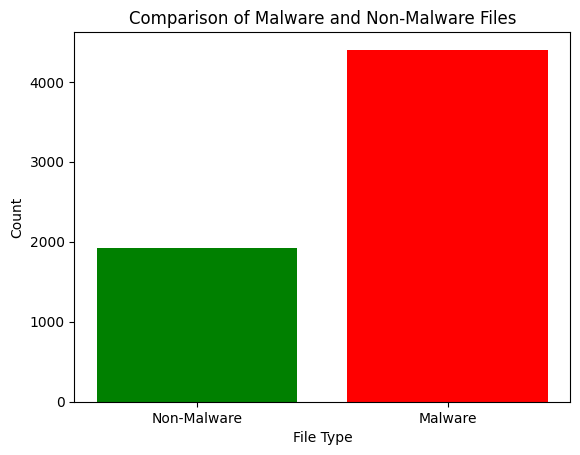

In [19]:
# Calculate counts of malware and non-malware
malware_count =  sum(value for value in y_train if value == 1) # Summing the 1s (which represent malware)
non_malware_count = len(y_train) - malware_count  # Total count minus malware count

# Bar chart
categories = ['Non-Malware', 'Malware']
counts = [non_malware_count, malware_count]

plt.bar(categories, counts, color=['green', 'red'])
plt.xlabel('File Type')
plt.ylabel('Count')
plt.title('Comparison of Malware and Non-Malware Files')
plt.show()
#after plotting the grapth we can see that the data is imbalanced it might cause some
#problems to the model as well

***Deal with imbalanced data***
* Reference: [Deal with imbalanced data](https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100) 

In [20]:
# import necessary libs
from sklearn.utils import resample

In [21]:
from sklearn.utils import resample


# concatenate our training data back together
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
# Separate majority and minority classes
df_majority = df[df.Malware==0]
df_minority = df[df.Malware==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=1234) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Malware.value_counts()

Malware
0    1919
1    1919
Name: count, dtype: int64

In [22]:
y_train_v1 = df_upsampled["Malware"]
x_train_v1 = df_upsampled.drop(columns = ["Malware"])
print("The Malware are remove successfully")

The Malware are remove successfully


In [23]:
#test value of y_train after downscale
y_train_v1.value_counts()

Malware
0    1919
1    1919
Name: count, dtype: int64

In [24]:
x_train_v1.shape

(3838, 24)

# **Train Model with resampling data**

In [25]:

r_model = Sequential()
r_model.add(Dense(24, input_shape=(24,))) # Increase neurons
r_model.add(Dense(16, activation='relu'))  # Add more layers
r_model.add(Dropout(0.3))
r_model.add(Dense(16, activation='relu'))  # Add more layers
r_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0015)  # Set learning rate sdirectly
r_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

d:\Federated_Learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
history = r_model.fit(x_train_v1,y_train_v1,batch_size = 32,epochs = 20,validation_data=[X_test, y_test])

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6146 - loss: 0.6690 - val_accuracy: 0.8297 - val_loss: 0.5031
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8117 - loss: 0.4915 - val_accuracy: 0.9158 - val_loss: 0.3058
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8735 - loss: 0.3466 - val_accuracy: 0.9228 - val_loss: 0.2278
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8851 - loss: 0.3156 - val_accuracy: 0.9367 - val_loss: 0.2042
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9105 - loss: 0.2649 - val_accuracy: 0.9247 - val_loss: 0.2302
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9161 - loss: 0.2677 - val_accuracy: 0.9449 - val_loss: 0.1887
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9224 - loss: 0.2442 - val_accuracy: 0.9449 - val_loss: 0.1742
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9173 - loss: 0.2562 - val_accuracy: 0.

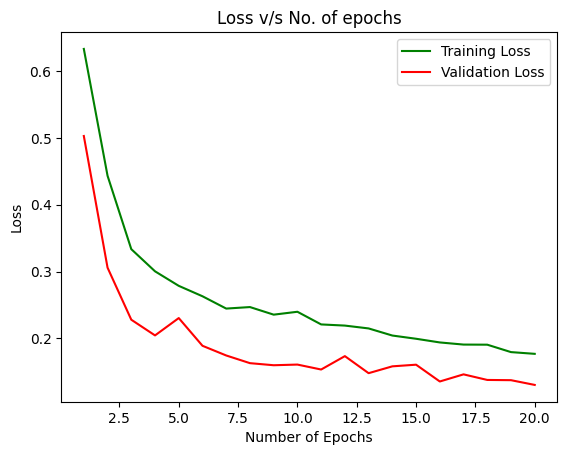

In [27]:
import keras
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss v/s No. of epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***Evaluation on test data***

In [28]:
loss,accuracy = r_model.evaluate(X_test,y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9620 - loss: 0.1382


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predict probabilities
prob_predictions = r_model.predict(X_test)

# Convert probabilities to binary class labels
binary_predictions = (prob_predictions >= 0.5).astype(int)

# Calculate custom metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.9658227848101266
Precision: 0.9745222929936306
Recall: 0.9762989972652689


***Confusion matrix***

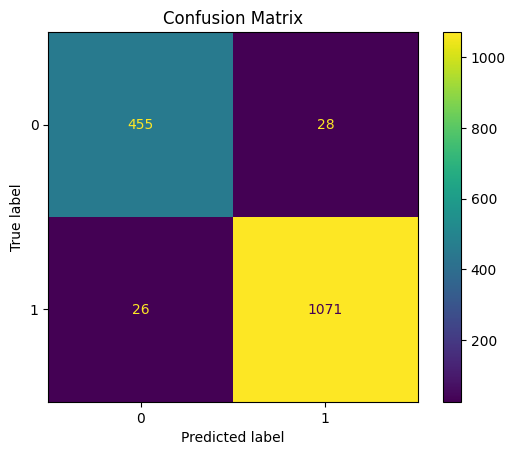

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(
   y_test,binary_predictions)
cm_display.ax_.set_title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report
# Generate classification report
report_dict = classification_report(y_test, binary_predictions, output_dict=True)

# Convert the dictionary to a DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Display the classification report DataFrame
print(report_df)

              precision    recall  f1-score      support
0              0.945946  0.942029  0.943983   483.000000
1              0.974522  0.976299  0.975410  1097.000000
accuracy       0.965823  0.965823  0.965823     0.965823
macro avg      0.960234  0.959164  0.959697  1580.000000
weighted avg   0.965787  0.965823  0.965803  1580.000000


***Save model***

In [32]:
r_model.save("1_save_resampling_model.h5")

In [33]:
test_df = pd.read_csv("test_extractor.csv")

In [34]:
test_df["Malware"] = 0

In [35]:
test_df.shape

(6, 66)

In [36]:
test_df = test_df[selected_columns]

In [37]:
target = test_df["Malware"]

In [38]:
features_df = test_df.drop(columns=["Malware"])

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler_v1 = MinMaxScaler()

In [40]:
test_scales = scaler_v1.fit_transform(features_df)

In [41]:
test_scales.shape

(6, 24)

In [42]:
loss, accuracy = r_model.evaluate(test_scales, target, verbose=0)

In [43]:
print(accuracy)

0.3333333432674408
